In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

Shape: torch.Size([3, 223, 320]), Dtype: torch.float32
Shape: torch.Size([3, 375, 500]), Dtype: torch.float32


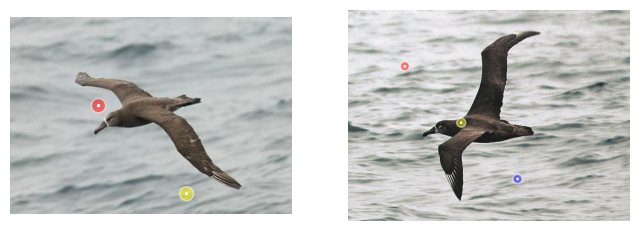

In [5]:
# This is the test code for above two functions : draw_correspondences and imsc
# It should display two images with points marked on them.
from PIL import Image
import matplotlib.pyplot as plt

# change the file path to your own
image1 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg')
image2 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg')

# check the file path
# image1.show()
# image2.show()

image1_tensor = pil_to_tensor(image1).float()  # convert to tensor
image2_tensor = pil_to_tensor(image2).float()

print(f"Shape: {image1_tensor.shape}, Dtype: {image1_tensor.dtype}")
print(f"Shape: {image2_tensor.shape}, Dtype: {image2_tensor.dtype}")

points1 = [(100, 100), (200, 200), (300, 200)]
points2 = [(100, 100), (200, 200), (300, 300)]


fig = draw_correspondences(points1, points2, image1_tensor, image2_tensor)

plt.show()


In [6]:
#@title create dataset


from transformers import AutoProcessor, CLIPProcessor,CLIPVisionModelWithProjection


# CLIP Model for image, pre-processing
# processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# Load the parts file, remember to change the path to your own
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]


class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


variable x: tensor([[[ 0.9522,  0.9668,  0.9668,  ...,  0.3975,  0.3537,  0.3245],
         [ 0.9376,  0.9522,  0.9522,  ...,  0.3829,  0.3537,  0.3537],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.3975,  0.3391,  0.3099],
         ...,
         [ 0.4997,  0.4559,  0.4413,  ..., -0.1864, -0.1864, -0.2010],
         [ 0.4705,  0.4559,  0.4413,  ..., -0.1864, -0.1718, -0.1718],
         [ 0.4997,  0.4705,  0.3975,  ..., -0.1718, -0.2010, -0.2156]],

        [[ 0.9343,  0.9493,  0.9643,  ...,  0.4991,  0.4540,  0.4240],
         [ 0.9193,  0.9493,  0.9493,  ...,  0.4841,  0.4540,  0.4540],
         [ 0.9193,  0.9193,  0.9193,  ...,  0.4991,  0.4540,  0.4240],
         ...,
         [ 0.6041,  0.5591,  0.5441,  ..., -0.1463, -0.1463, -0.1613],
         [ 0.5741,  0.5591,  0.5441,  ..., -0.1463, -0.1313, -0.1313],
         [ 0.6041,  0.5741,  0.4991,  ..., -0.1313, -0.1613, -0.1763]],

        [[ 0.8234,  0.8377,  0.8234,  ...,  0.2546,  0.2120,  0.1835],
         [ 0.8092,  0.8092,  0.82

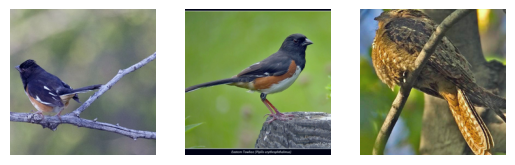

In [7]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/' # You need to change this.
base_path = '../data/CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

# data_indices.append(856)
# data_indices.append(858)
# data_indices.append(924)

data_indices.append(624)
data_indices.append(615)
data_indices.append(632)

for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)
  print(f"variable x: {x}")
  print(f"variable y: {y}")

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [8]:
#@title load model

from transformers import CLIPVisionConfig, CLIPVisionModel, CLIPModel, CLIPVisionModelWithProjection

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.
# configuration = CLIPVisionConfig()
# model = CLIPVisionModel(configuration).to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to('cuda')

# text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')


inpus: [tensor([[[ 0.9522,  0.9668,  0.9668,  ...,  0.3975,  0.3537,  0.3245],
         [ 0.9376,  0.9522,  0.9522,  ...,  0.3829,  0.3537,  0.3537],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.3975,  0.3391,  0.3099],
         ...,
         [ 0.4997,  0.4559,  0.4413,  ..., -0.1864, -0.1864, -0.2010],
         [ 0.4705,  0.4559,  0.4413,  ..., -0.1864, -0.1718, -0.1718],
         [ 0.4997,  0.4705,  0.3975,  ..., -0.1718, -0.2010, -0.2156]],

        [[ 0.9343,  0.9493,  0.9643,  ...,  0.4991,  0.4540,  0.4240],
         [ 0.9193,  0.9493,  0.9493,  ...,  0.4841,  0.4540,  0.4540],
         [ 0.9193,  0.9193,  0.9193,  ...,  0.4991,  0.4540,  0.4240],
         ...,
         [ 0.6041,  0.5591,  0.5441,  ..., -0.1463, -0.1463, -0.1613],
         [ 0.5741,  0.5591,  0.5441,  ..., -0.1463, -0.1313, -0.1313],
         [ 0.6041,  0.5741,  0.4991,  ..., -0.1313, -0.1613, -0.1763]],

        [[ 0.8234,  0.8377,  0.8234,  ...,  0.2546,  0.2120,  0.1835],
         [ 0.8092,  0.8092,  0.8234, 

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


outputs: CLIPVisionModelOutput(image_embeds=tensor([[ 2.7084e-02,  4.6854e-01, -1.6508e-01, -1.5883e-01,  2.7963e-01,
         -1.2986e-01,  4.9868e-01,  6.3007e-01,  1.0597e-01,  2.4482e-01,
          5.8465e-02,  3.7811e-01, -2.6471e-01, -3.2221e-02,  2.6269e-01,
         -9.3732e-02, -3.8645e-01,  3.8509e-02, -7.1956e-02,  2.3484e-01,
          2.1826e-01, -2.4335e-01,  6.7772e-02, -1.6117e-01, -4.4439e-01,
         -5.3901e-02, -2.2087e-02,  4.9903e-01, -3.7790e-01,  5.0915e-02,
          1.8495e-01, -2.6931e-01,  1.1853e-01,  3.4760e-01, -1.5139e-01,
          1.8610e-01, -2.1956e-01, -2.8783e-01, -2.5103e-01, -9.0700e-01,
         -1.7302e-01,  2.5942e-02, -1.2944e-01, -3.1839e-01, -1.2760e-01,
         -4.4174e-01, -1.2348e-01,  3.9182e-02,  4.6177e-01, -2.1858e-02,
         -2.9110e-01, -1.5442e-01,  5.3706e-01, -1.3199e-01, -4.4844e-01,
          2.2544e-01,  5.2597e-02,  2.6195e-01,  6.9750e-01,  9.1650e-02,
         -7.1800e-02, -5.8553e-01, -2.5400e-01, -1.2340e-01, -4.4362

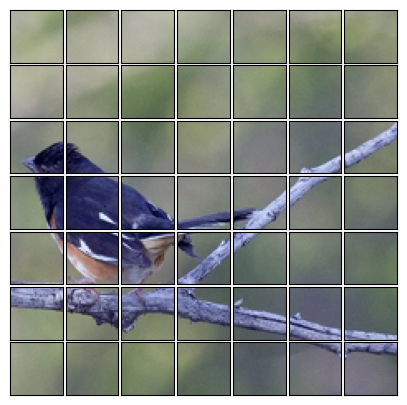

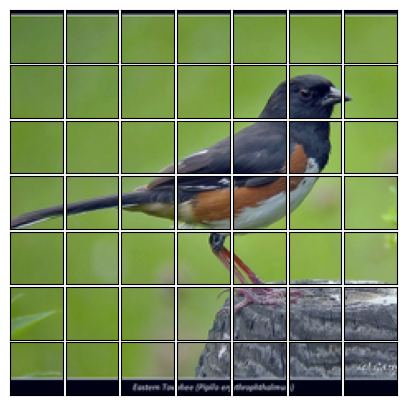

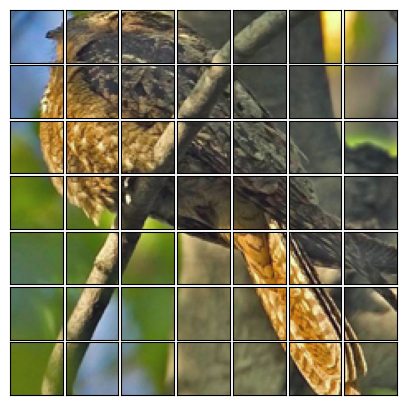

In [9]:
#@title plot patches

print(f"inpus: {inputs}")
for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    # original permute(0,1,2) -> (C,H,W)
    print(f"img shape before: {img.shape}")
    img = img.permute(1, 2, 0)
    print(f"img shape after: {img.shape}")
    

    H, W, C = img.shape
    # new shape (H, W, C)
    print(f"img shape: {img.shape}")

    # create a random tensor with the same shape as the input image, batch size 1
    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    # dummy_input = img.unsqueeze(0).to('cuda')

    outputs = vision_model(dummy_input)  
    # outputs = model(pixel_values=img.unsqueeze(0).to('cuda'))  # 增加 batch 维度
    print(f"outputs: {outputs}")

    # 256 patches, 1024 features
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    print(f"NUMBER_OF_PATCHES: {NUMBER_OF_PATCHES}")
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size
    print("patch size is: ", PATCH_SIZE)
    # patch_width = 14, not 14, it should be 16
    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width
    # n_rows = 16, n_cols = 16

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]
    print(f"cropped_img shape: {cropped_img.shape}")
    

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    # create pathes 
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



input shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 50, 768])
torch.Size([50, 512])
embedding shape: (49, 512)
input shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 50, 768])
torch.Size([50, 512])
embedding shape: (49, 512)
input shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 50, 768])
torch.Size([50, 512])
embedding shape: (49, 512)
['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right eye', 'right leg', 'right wing', 'tail', 'throat', 'background', 'blue wings', 'brown wings', 'iridescent wings', 'purple wings', 'rufous wings', 'grey wings', 'yellow wings', 'olive wings', 'green wings', 'pink wings', 'orange wings', 'black wings', 'white wings', 'red wings', 'buff wings', 'blue upperparts', 'brown upperparts', 'iridescent upperparts', 'purple upperparts', 'rufous upperparts', 'grey upperparts', 'yellow upperparts', 'olive upperparts', 'green upperparts', 'pink upperparts', 'orange upperparts', 'black upperparts', 'whi

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model device: cuda:0
new_outputs: CLIPTextModelOutput(text_embeds=tensor([[ 0.0404, -0.1788, -0.4574,  ..., -0.2914, -0.0781,  0.0596],
        [ 0.0729,  0.0685, -0.0647,  ..., -0.1754, -0.1775, -0.0584],
        [ 0.0935,  0.3341, -0.4936,  ..., -0.4816, -0.3133, -0.0151],
        ...,
        [-0.0575, -0.0423,  0.3200,  ...,  0.1650, -0.2420, -0.2655],
        [-0.2021, -0.1271, -0.2458,  ...,  0.2123, -0.6223, -0.0829],
        [ 0.0177,  0.1091, -0.2716,  ...,  0.0962, -0.3105, -0.0314]],
       device='cuda:0', grad_fn=<MmBackward0>), last_hidden_state=tensor([[[ 3.3929e-01,  1.1646e-01,  1.0195e-01,  ...,  2.4677e-01,
           5.9064e-01,  1.0130e-01],
         [ 3.1105e-01, -5.1377e-02, -2.7974e-01,  ...,  1.6636e+00,
           2.2058e-01,  4.3526e-01],
         [ 1.3919e+00, -1.1066e+00,  3.2517e-02,  ...,  1.2591e+00,
           2.7766e-01, -1.6070e+00],
         ...,
         [ 1.5073e+00, -1.2089e+00,  2.4496e-02,  ...,  1.1167e+00,
           3.1436e-01, -1.5403e+00],


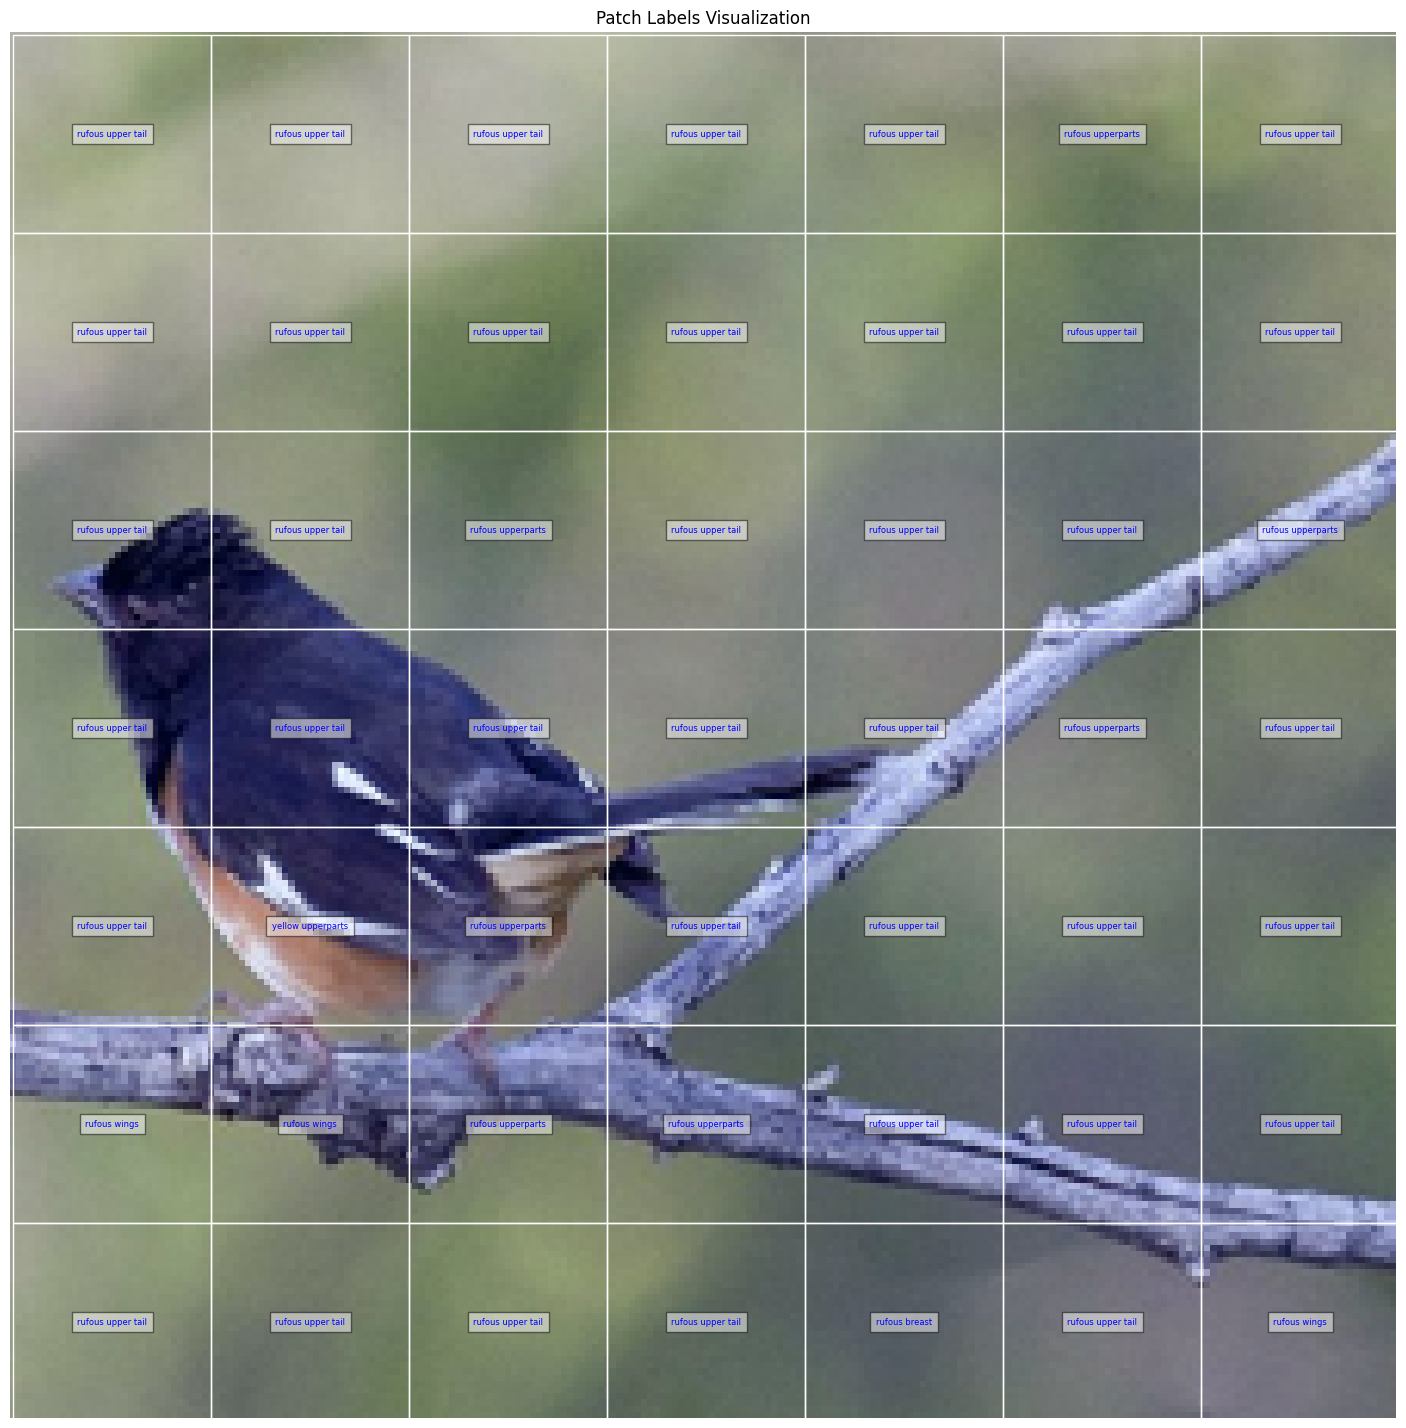

Visualizing Image 1...
Number of patches: 49
Number of labels: 49
Patches coordinates: [(0, 0), (32, 0), (64, 0), (96, 0), (128, 0), (160, 0), (192, 0), (0, 32), (32, 32), (64, 32), (96, 32), (128, 32), (160, 32), (192, 32), (0, 64), (32, 64), (64, 64), (96, 64), (128, 64), (160, 64), (192, 64), (0, 96), (32, 96), (64, 96), (96, 96), (128, 96), (160, 96), (192, 96), (0, 128), (32, 128), (64, 128), (96, 128), (128, 128), (160, 128), (192, 128), (0, 160), (32, 160), (64, 160), (96, 160), (128, 160), (160, 160), (192, 160), (0, 192), (32, 192), (64, 192), (96, 192), (128, 192), (160, 192), (192, 192)]
Labels: ['rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous

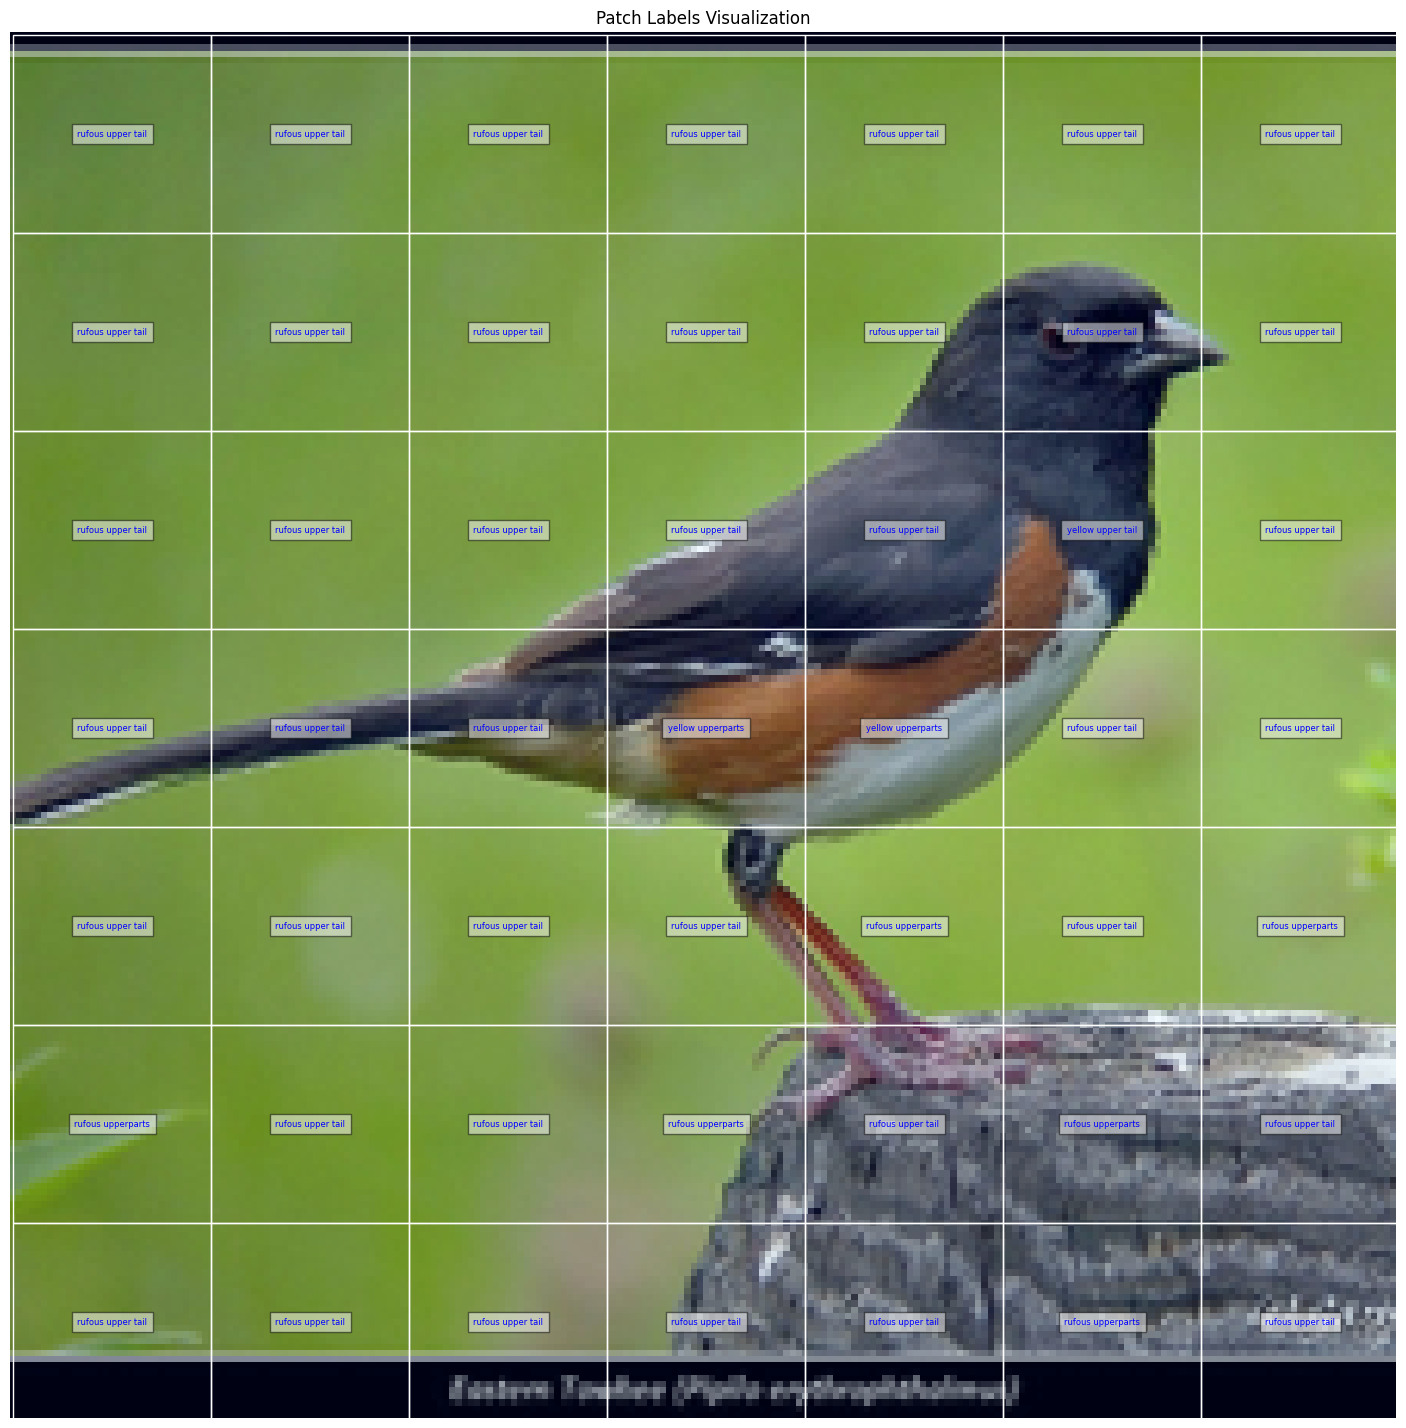

Visualizing Image 2...
Number of patches: 49
Number of labels: 49
Patches coordinates: [(0, 0), (32, 0), (64, 0), (96, 0), (128, 0), (160, 0), (192, 0), (0, 32), (32, 32), (64, 32), (96, 32), (128, 32), (160, 32), (192, 32), (0, 64), (32, 64), (64, 64), (96, 64), (128, 64), (160, 64), (192, 64), (0, 96), (32, 96), (64, 96), (96, 96), (128, 96), (160, 96), (192, 96), (0, 128), (32, 128), (64, 128), (96, 128), (128, 128), (160, 128), (192, 128), (0, 160), (32, 160), (64, 160), (96, 160), (128, 160), (160, 160), (192, 160), (0, 192), (32, 192), (64, 192), (96, 192), (128, 192), (160, 192), (192, 192)]
Labels: ['rufous breast', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upperparts', 'iridescent back', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upperparts', 'rufous wings', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail', 'rufous upper tail

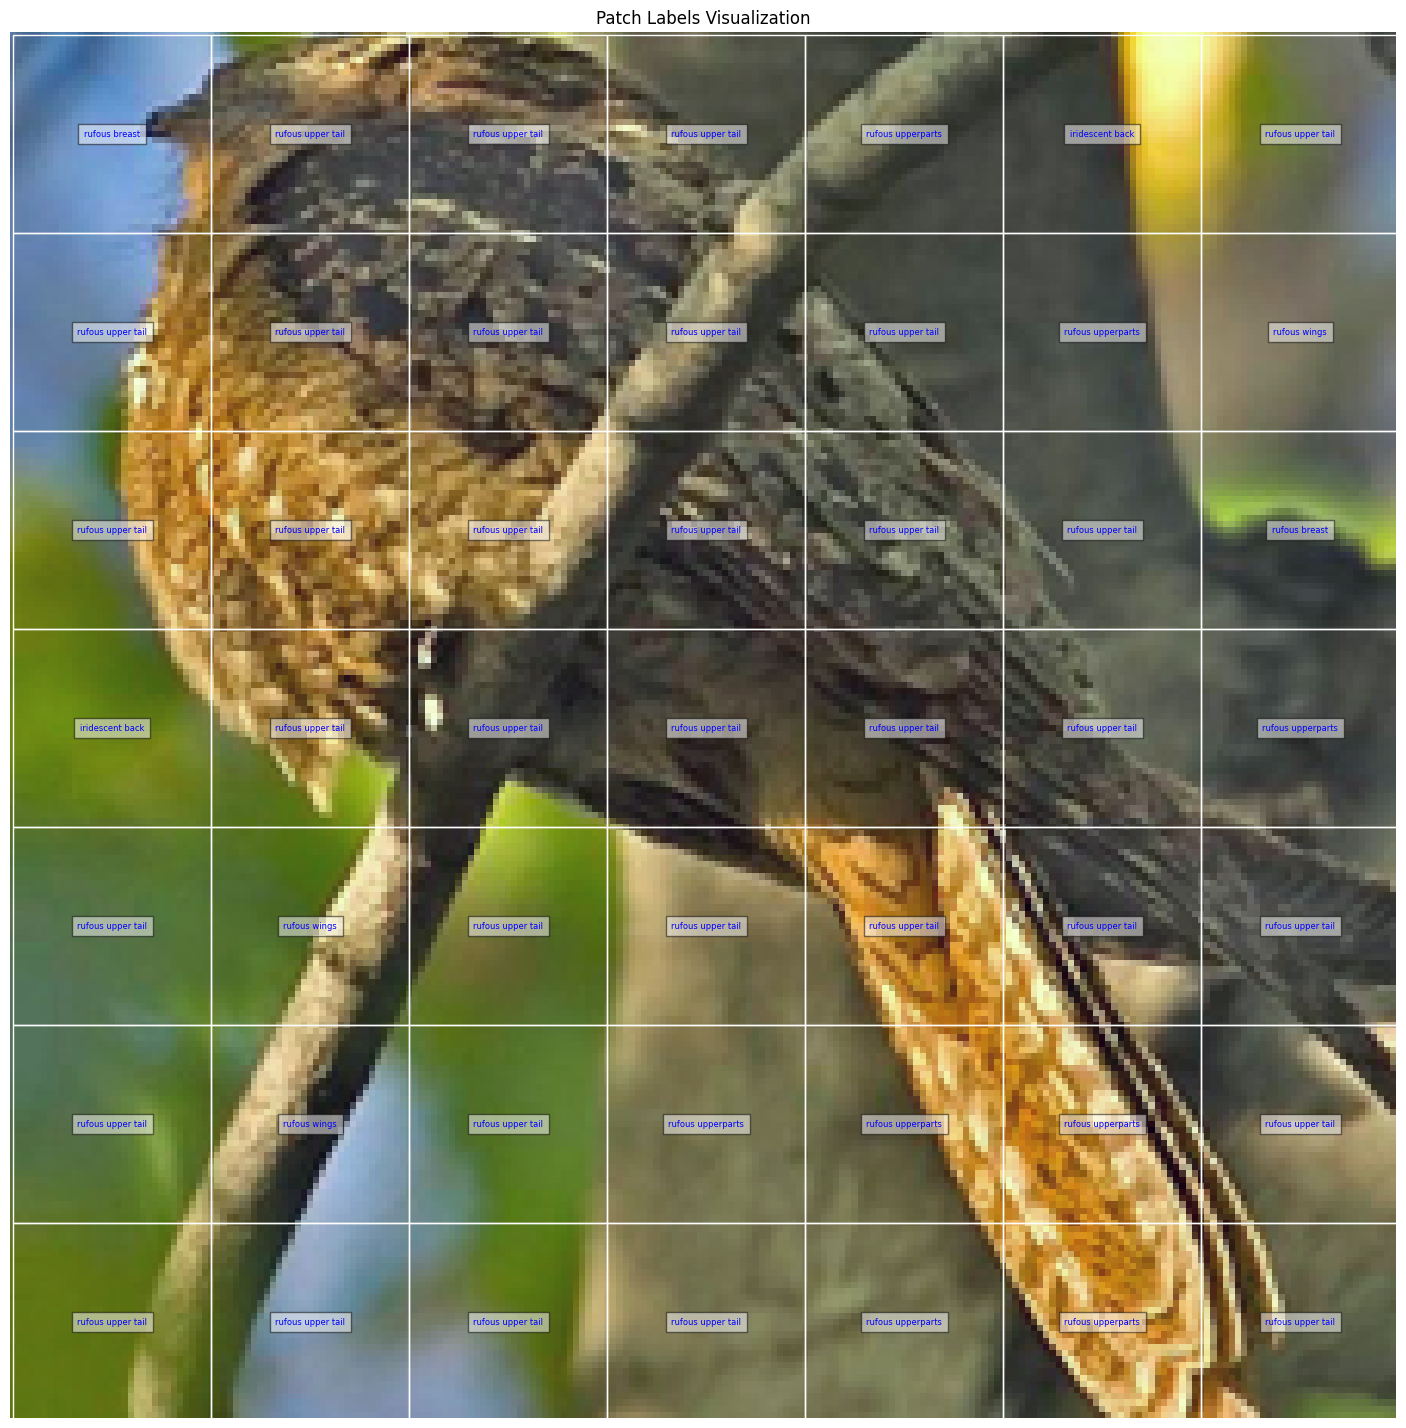

In [10]:
#@title create patch embeddings

device='cuda'

embedings = []

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)
        print(f"input shape:", input_i.shape)
        # vision model with input image
        outputs = vision_model(input_i, output_hidden_states=True)
        image_embeds = outputs.image_embeds
        # Extract and normalize the last_hidden_state
        hidden_states_in_last_layer = outputs.hidden_states[-1]
        print(hidden_states_in_last_layer.shape)
        projected_patches = vision_model.visual_projection(hidden_states_in_last_layer[0])
        print(projected_patches.shape)
        last_hidden_state_last_layer = nn.functional.normalize(projected_patches, p=2, dim=-1)
        # last_hidden_state: (batch_size, sequence_length, hidden_size)
        # embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))
        # embedings.append(last_hidden_state_last_layer[0, 1:, :].cpu().numpy())
        embedings.append(last_hidden_state_last_layer[1:, :].cpu().numpy())
        print(f"embedding shape:",embedings[counter].shape)

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]
    
print(parts)

from transformers import AutoTokenizer, CLIPTextModel,CLIPTextModelWithProjection
from torch.nn.functional import cosine_similarity


# text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")


# Print the model device
print("Model device:", next(text_model.parameters()).device)

# Tokenize parts
text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
text_inputs = {key: value.to(device) for key, value in text_inputs.items()}

new_outputs = text_model(**text_inputs, output_hidden_states=True)
print("new_outputs:", new_outputs)
# text_hidden_states_in_last_layer = new_outputs.hidden_states[-1]
# text_projected_patches = text_model.text_projection(text_hidden_states_in_last_layer[0])
# text_new_last_hidden_state = nn.functional.normalize(text_projected_patches, p=2, dim=-1)
# text_embeds = text_new_last_hidden_state
text_embeds = new_outputs.text_embeds
parts_embeddings = text_embeds
print(f"Parts embeddings shape: {parts_embeddings.shape}")


# Process each image's patch embeddings
matched_labels = []
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = torch.tensor(patch_embedding, device=device) # Shape: (num_patches, 768) 
    print(f"Patch embedding shape: {patch_embedding.shape}")
    # projected_patch_embedding = projection_layer(patch_embedding)  
    # print(f"Projected patch embedding shape: {projected_patch_embedding.shape}")
    # Calculate cosine similarity between each patch and each part
    similarity_matrix = cosine_similarity(
        patch_embedding.unsqueeze(1),             # Shape: (num_patches, embedding_dim)
        parts_embeddings.unsqueeze(0),            # Shape: (num_parts, embedding_dim)
        dim=-1                                    # compute the cosine similarity along the last dimension
    )
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    
    # Find the part with the highest similarity for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)  # Shape: (num_patches,)
    print(f"Best match indices : {best_match_indices}")
    print(f"Best match indices shape: {best_match_indices.shape}")
    labels = [parts[idx] for idx in best_match_indices]  # every image has 49 patches, each patch has a label
    matched_labels.append(labels)  # append the patch labels for each image
    
# print the matched labels for each image
for img_idx, labels in enumerate(matched_labels):
    print(f"Image {img_idx}: Matched labels for patches:")
    for patch_idx, label in enumerate(labels):
        print(f"  Patch {patch_idx}: {label}")

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def normalize_image(image):
    """Normalize the image to [0, 1] range for visualization."""
    return (image - image.min()) / (image.max() - image.min())

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_patch_coordinates(image, patch_size):
    """
    calculate the coordinates of the top-left corner of each patch.
    
    Args:
    - image (torch.Tensor) : input image, shape (C, H, W).
    - patch_size (int): size of each patch.

    Returns:
    - patch_coords (list): the top-left coordinates of each patch (x, y).
    """
    _, H, W = image.shape
    n_rows = H // patch_size
    n_cols = W // patch_size

    patch_coords = []
    for i in range(n_rows):
        for j in range(n_cols):
            x = j * patch_size
            y = i * patch_size
            patch_coords.append((x, y))
    return patch_coords

def visualize_patches_with_coordinates(image, patch_coords, matched_labels, patch_size=16):
    """
    use the precomputed coordinates and labels to annotate each patch.

    Args:
    - image (torch.Tensor): input image, shape (C, H, W).
    - patch_coords (list): every patch's top-left corner coordinates.
    - matched_labels (list): labels for each patch.
    - patch_size (int): size of each patch.
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # transform the image to (H, W, C)
    image = (image - image.min()) / (image.max() - image.min())  # normalize the image to [0, 1]

    # debug information
    print(f"Number of patches: {len(patch_coords)}")
    print(f"Number of labels: {len(matched_labels)}")
    print(f"Patches coordinates: {patch_coords}")
    print(f"Labels: {matched_labels}")

    # plot the figure
    plt.figure(figsize=(18, 18))
    plt.imshow(image)
    ax = plt.gca()

    # loop over all patch coordinates and labels
    for idx, ((x, y), label) in enumerate(zip(patch_coords, matched_labels)):
        print(f"Drawing patch {idx} at ({x}, {y}) with label '{label}'")  # 打印调试信息
        # draw a rectangle around the patch
        rect = patches.Rectangle(
            (x, y), patch_size, patch_size, linewidth=1, edgecolor='white', facecolor='none'
        )
        ax.add_patch(rect)
        
        # draw the label in the center of the patch
        plt.text(
            x + patch_size // 2, y + patch_size // 2, label,
            color="blue", fontsize=6, ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.5)
        )

    plt.axis("off")
    plt.title("Patch Labels Visualization")
    plt.show()


# visualize the patches with the matched labels for each image
patch_size = vision_model.config.patch_size
print(f"Patch size: {patch_size}")
for img_idx, (img, labels) in enumerate(zip(inputs, matched_labels)):
    print(f"Visualizing Image {img_idx}...")
    patch_coords = calculate_patch_coordinates(img, patch_size)  # calculate the patch coordinates
    visualize_patches_with_coordinates(img, patch_coords, labels, patch_size)




original code below

In [11]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

print(best_buddies_query_indices)




[12 14 15 20 23 29 31 33 35 37 42 43]


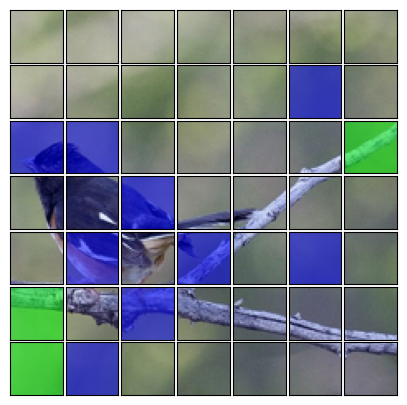

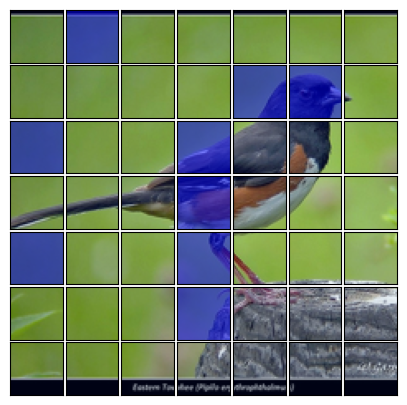

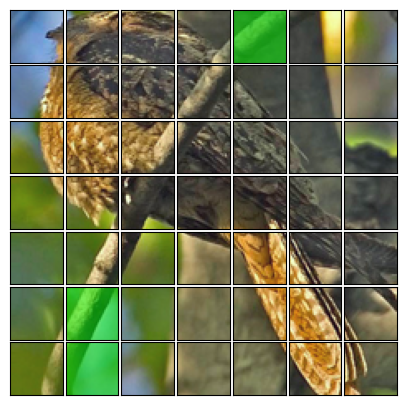

In [12]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




Explained variance ratio: [0.27746513 0.13851713 0.04654824 0.03944016 0.03077416 0.02863622
 0.02236223 0.02111788 0.01988533 0.0183769 ]


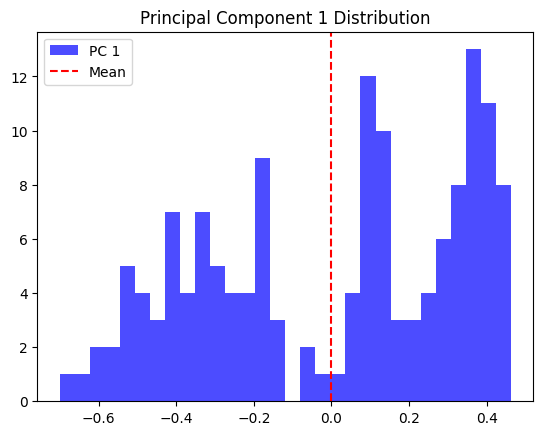

Principal Component 1 shows bimodal distribution.


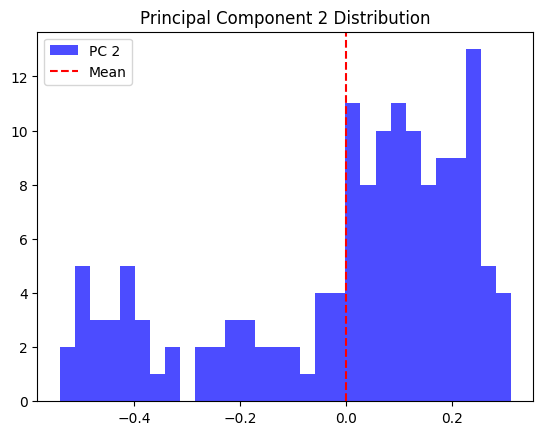

Principal Component 2 shows bimodal distribution.
Using the first principal component for foreground/background separation.
Original best_buddies count: 12
Filtered best_buddies count (foreground only): 5
Filtered best_buddies count (background only): 0
Best buddies query indices: [14 15 23 29 31]
Best buddies prototype indices: [12 11 17 24 31]


In [13]:
#@title STEP 2: find foreground and remove best buddies beloning to background

# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# # The following variable is important for the thresholding. You either set it to 0 or 1.
# # In the more complete code this happens automatically as you will see later.
# pca_component_to_threshold = 0
# pca_features = pca.fit_transform(np.concatenate(embedings))

# threshold = np.mean(pca_features[:, pca_component_to_threshold])
# foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
# foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

# prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
# prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
# prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

# print(sum(best_buddies))

# best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
# best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

# print(sum(best_buddies))

# best_buddies_query_indices = np.where(best_buddies == True)[0]
# best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
 
# Perform PCA analysis
pca = PCA(n_components=10)
pca_features = pca.fit_transform(np.concatenate(embedings))
 
# Calculate the explained variance ratio for principal components
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")
 
# Dynamically check if the principal components exhibit bimodal distribution
def check_bimodal_distribution(data, bins=30):
    """Check if the data exhibits a bimodal distribution"""
    hist, bin_edges = np.histogram(data, bins=bins)
    peaks = np.sum((hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:]))
    return peaks >= 2
 
# Plot histograms for the distribution of principal components
for i in range(2):  # Plot only the first two principal components
    plt.figure()
    plt.hist(pca_features[:, i], bins=30, alpha=0.7, color='blue', label=f'PC {i + 1}')
    plt.axvline(np.mean(pca_features[:, i]), color='red', linestyle='--', label='Mean')
    plt.title(f'Principal Component {i + 1} Distribution')
    plt.legend()
    plt.show()
    if check_bimodal_distribution(pca_features[:, i]):
        print(f"Principal Component {i + 1} shows bimodal distribution.")
 
# Select the principal component related to the foreground
if check_bimodal_distribution(pca_features[:, 0]):
    print("Using the first principal component for foreground/background separation.")
    pca_component_to_threshold = 0
elif check_bimodal_distribution(pca_features[:, 1]):
    print("Using the second principal component for foreground/background separation.")
    pca_component_to_threshold = 1
else:
    print("Defaulting to the first principal component.")
    pca_component_to_threshold = 0
 
# Calculate threshold
threshold_mean = np.mean(pca_features[:, pca_component_to_threshold])
threshold_std = 0.5 * np.std(pca_features[:, pca_component_to_threshold])
 
# Generate foreground and background masks
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold_mean + threshold_std
background_mask = pca_features[:, pca_component_to_threshold] < threshold_mean - threshold_std
 
# Convert masks to 2D format
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)
background_mask = np.array(background_mask).reshape(-1, NUMBER_OF_PATCHES)
 
# Get the coordinates of foreground and background patches
prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True
 
prototypes_background_new_coordinates = nearest_neighbor_prototypes[background_mask[1:].flatten()]
prototypes_background_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_background_mask_new_coordinates[prototypes_background_new_coordinates] = True
 
# Update best_buddies
print(f"Original best_buddies count: {sum(best_buddies)}")
 
best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])  # Filter by foreground
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)  # Keep only foreground-related
 
print(f"Filtered best_buddies count (foreground only): {sum(best_buddies)}")
 
# Optionally process background-related best_buddies
best_buddies_background = np.bitwise_and(best_buddies, background_mask[0])  # Filter by background
best_buddies_background = np.bitwise_and(best_buddies_background, prototypes_background_mask_new_coordinates)
 
print(f"Filtered best_buddies count (background only): {sum(best_buddies_background)}")
 
# Extract indices for queries and prototypes
best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]
 
# Output debug information
print(f"Best buddies query indices: {best_buddies_query_indices}")
print(f"Best buddies prototype indices: {best_buddies_prototypes_indices}")

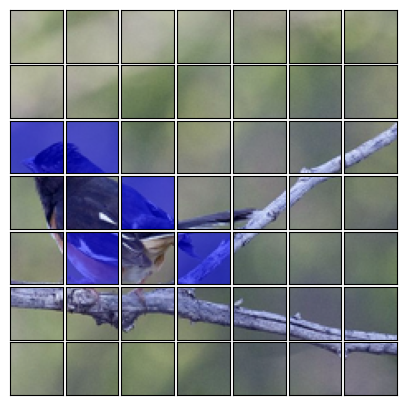

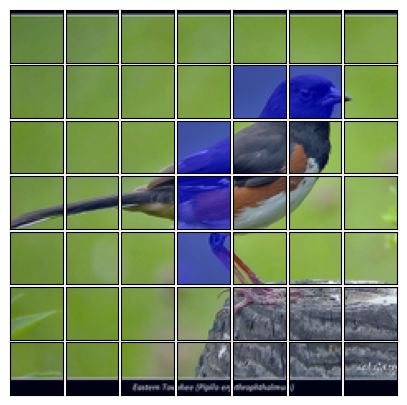

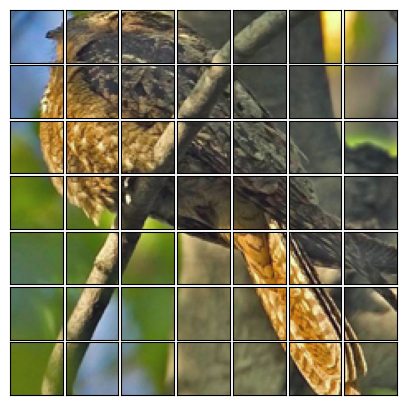

In [14]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [15]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 5 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


[23 15 31 29 14]
[17 11 31 24 12]


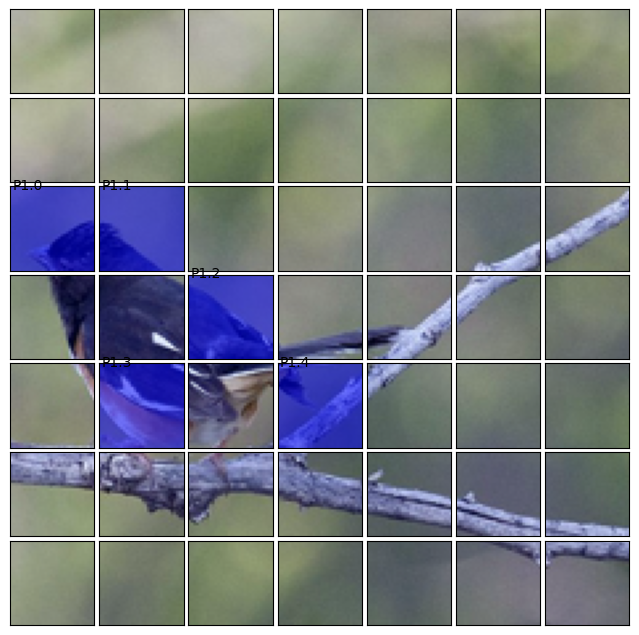

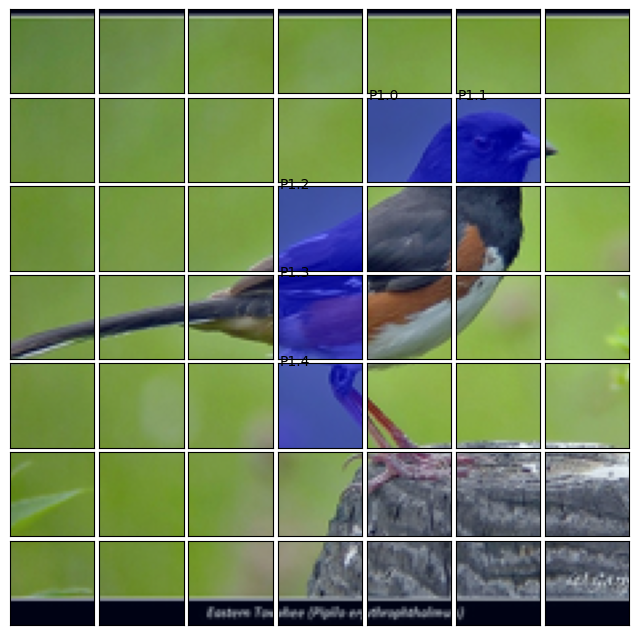

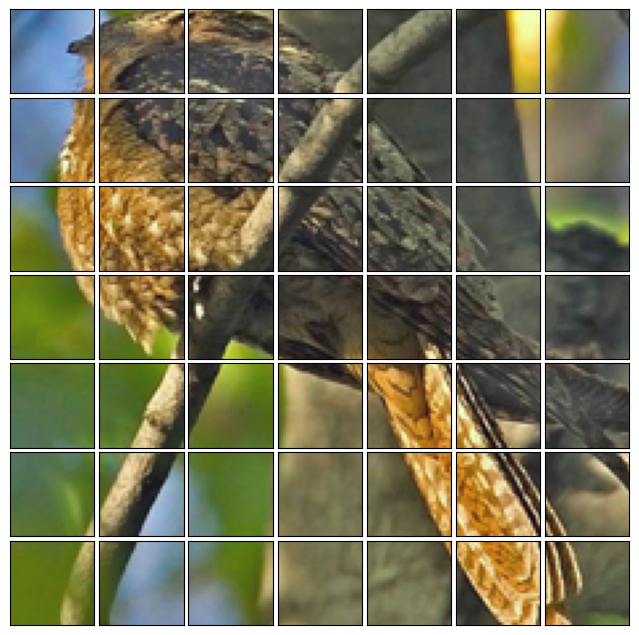

In [16]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = vision_model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = vision_model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




Query - Index: 14, Label: rufous upper tail
Query - Index: 15, Label: rufous upper tail
Query - Index: 23, Label: rufous upper tail
Query - Index: 29, Label: yellow upperparts
Query - Index: 31, Label: rufous upper tail


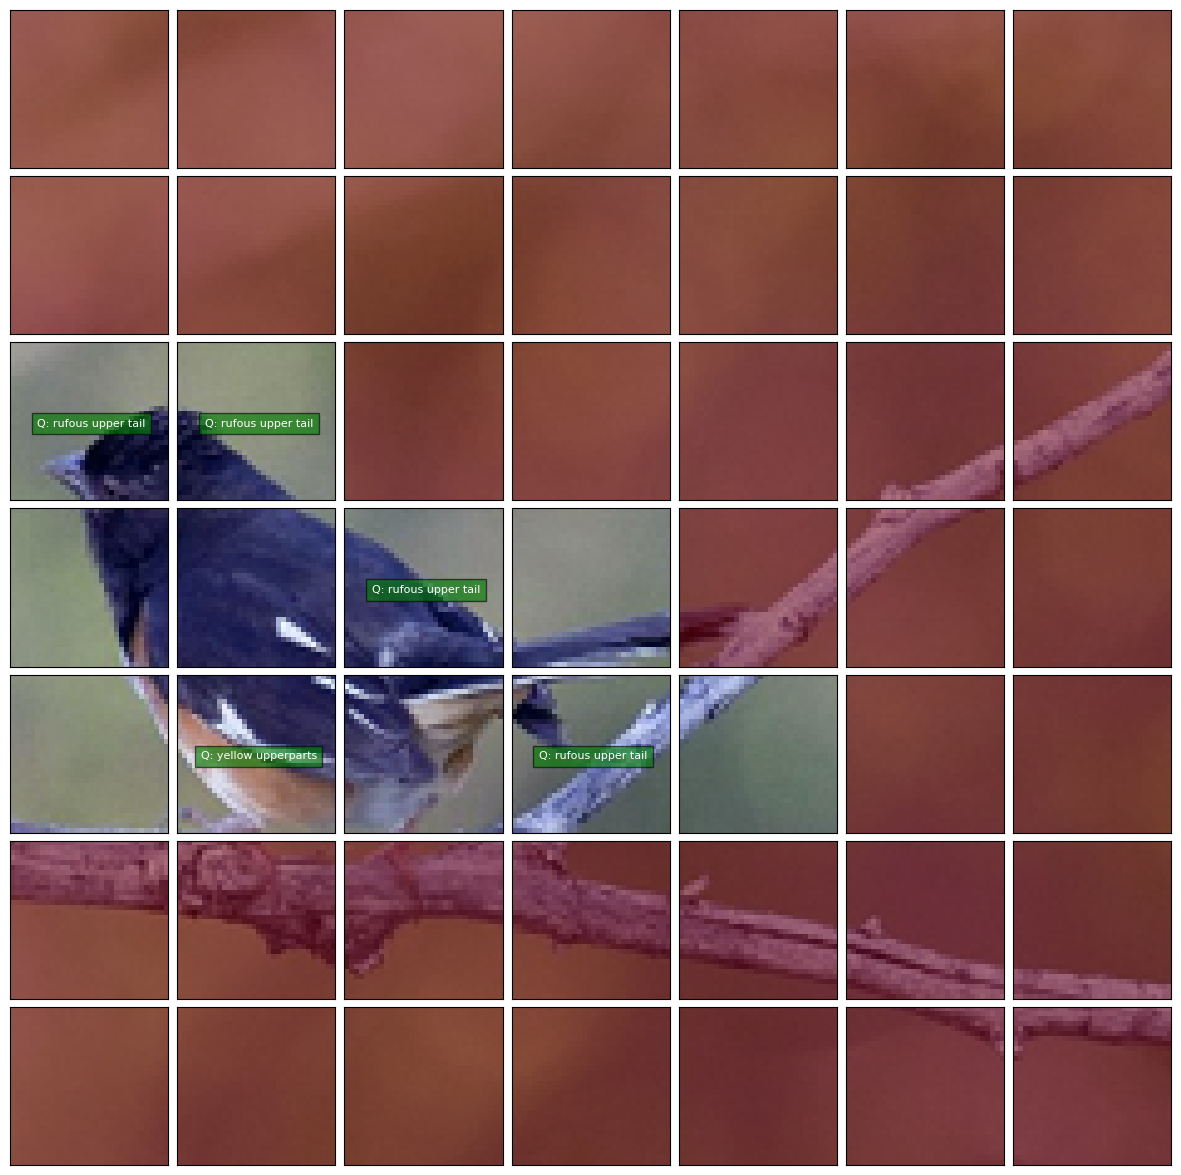

Prototype - Index: 11, Label: rufous upper tail
Prototype - Index: 12, Label: rufous upper tail
Prototype - Index: 17, Label: rufous upper tail
Prototype - Index: 24, Label: yellow upperparts
Prototype - Index: 31, Label: rufous upper tail


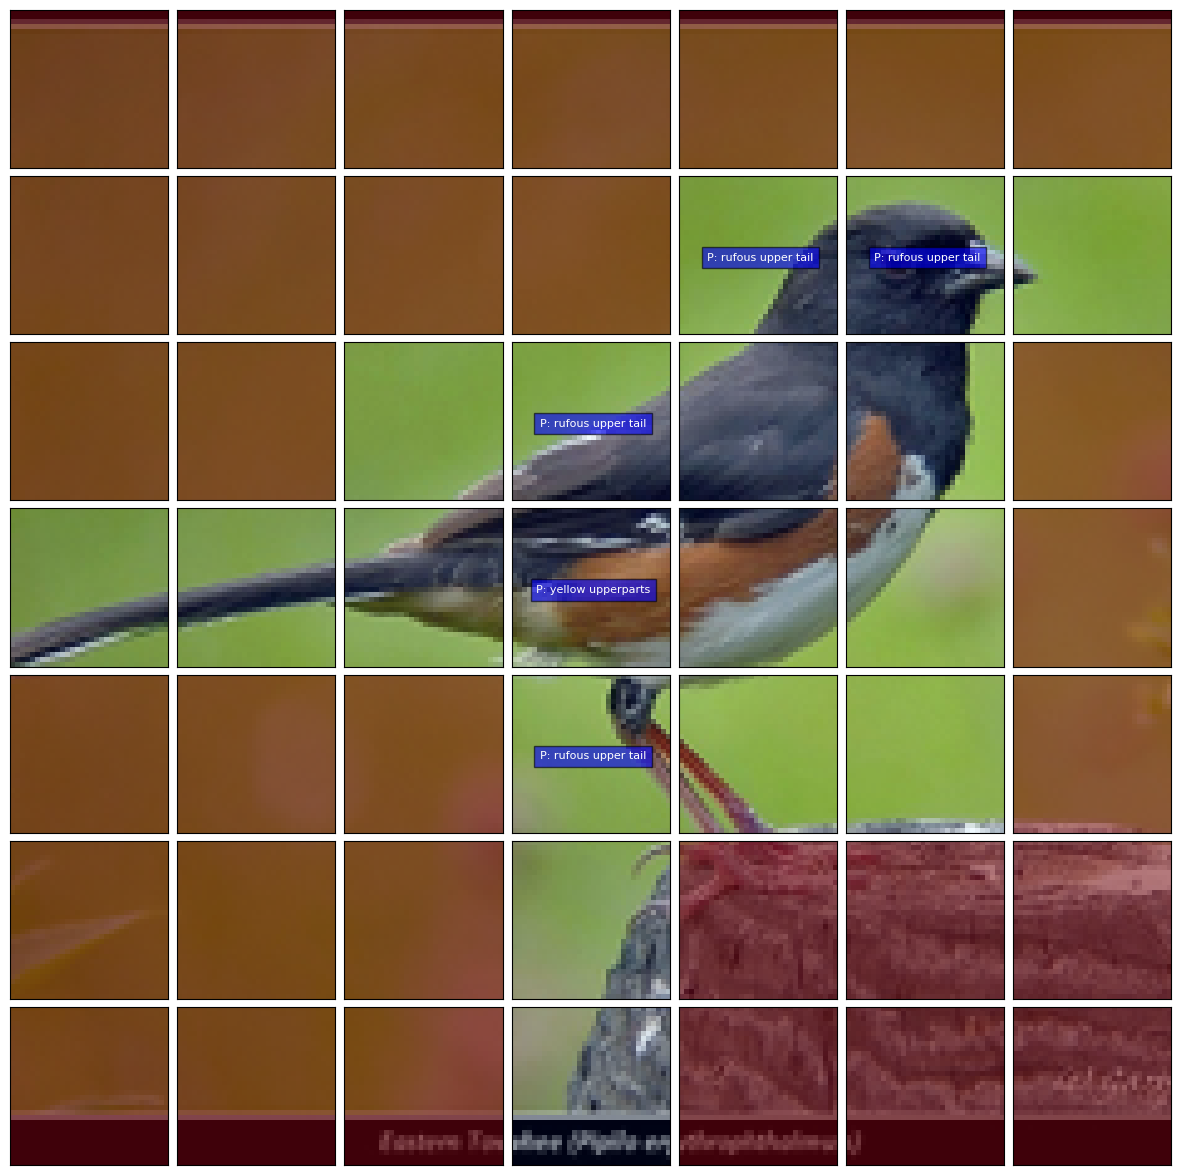

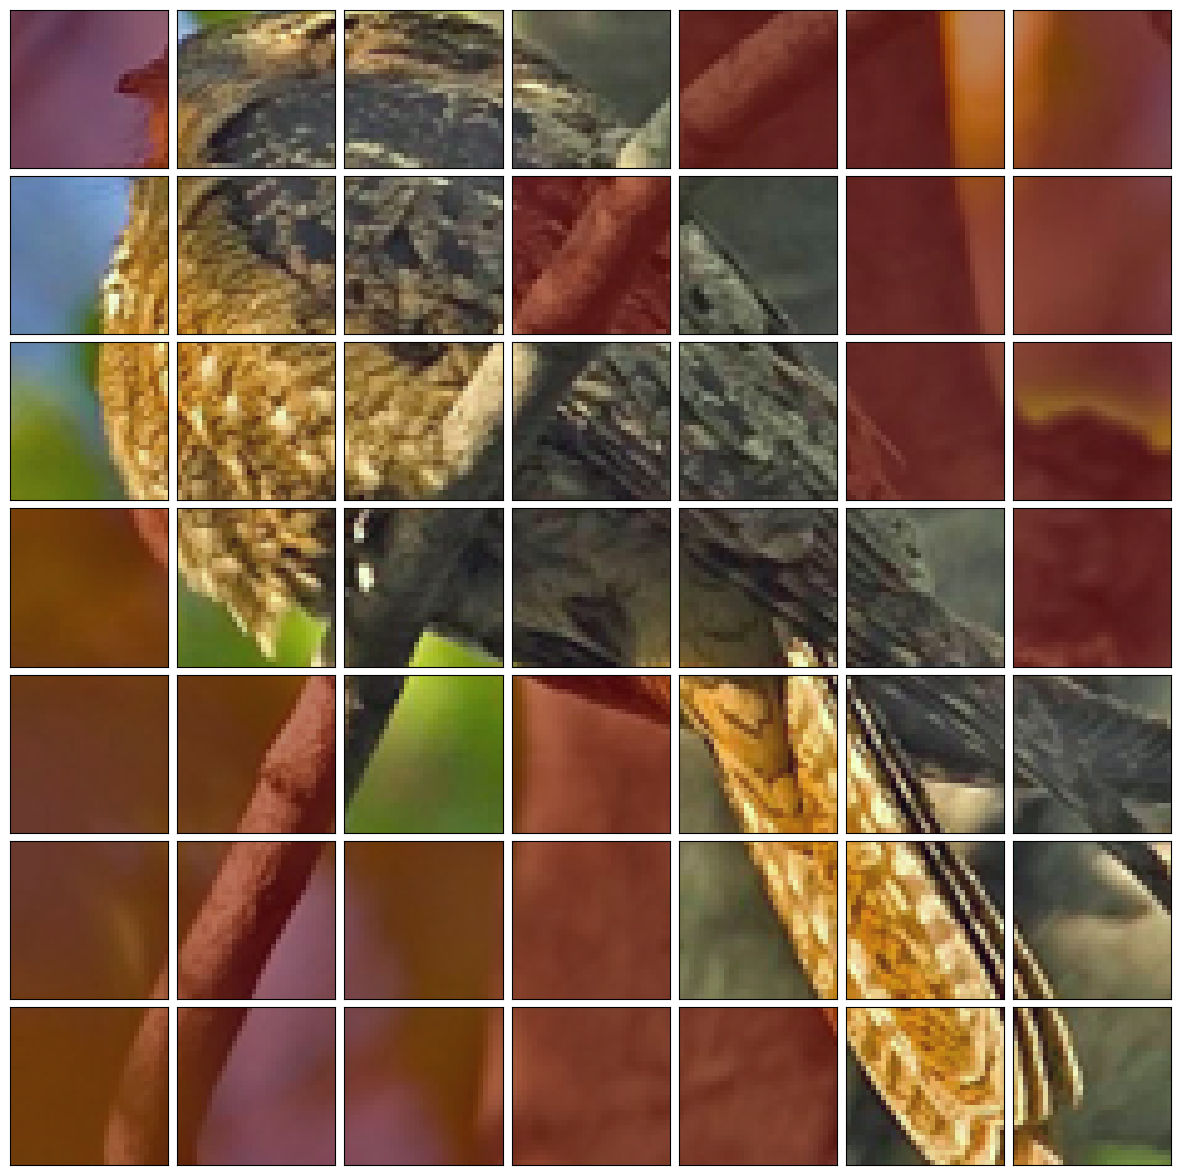

In [17]:
for counter, img in enumerate(inputs):

    # Transform image dimensions (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0)
    H, W, C = img.shape

    # Dynamically retrieve PATCH_SIZE
    PATCH_SIZE = vision_model.config.patch_size  # 32
    # print("patch size is: ", PATCH_SIZE)
    n_rows = H // PATCH_SIZE
    n_cols = W // PATCH_SIZE

    # Crop the image to fit PATCH_SIZE
    cropped_img = img[:n_rows * PATCH_SIZE, :n_cols * PATCH_SIZE, :]

    # Divide the image into patches
    patches = torch.empty(n_rows, n_cols, PATCH_SIZE, PATCH_SIZE, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, PATCH_SIZE, n_cols, PATCH_SIZE)
            .permute(0, 2, 1, 3)
        )

    # Visualization settings
    f, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            patch_idx = n_rows * row_idx + col_idx  # Current patch index
            axs[row_idx, col_idx].imshow(
                imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()])
            )

            # Mask background areas (using foreground_mask)
            if not foreground_mask[counter, patch_idx]:
                color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                color_shading[:, :, 0] = 128  # Gray shading to indicate background
                axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                continue

            # Add text labels to highlighted areas and print indices
            if counter == 0 and patch_idx in best_buddies_query_indices:
                label = matched_labels[counter][patch_idx]  # Retrieve matching label from `matched_labels`
                text_label = f"Q: {label}"  # Query label
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="green", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Query - Index: {patch_idx}, Label: {label}")  # Print index and label

            elif counter == 1 and patch_idx in best_buddies_prototypes_indices:
                label = matched_labels[counter][patch_idx]  # Retrieve matching label from `matched_labels`
                text_label = f"P: {label}"  # Prototype label
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="blue", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Prototype - Index: {patch_idx}, Label: {label}")  # Print index and label

            elif counter == 2 and (patch_idx + NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                label = matched_labels[counter][patch_idx]  # Retrieve matching label from `matched_labels`
                text_label = f"P2: {label}"  # Green prototype label
                axs[row_idx, col_idx].text(
                    PATCH_SIZE // 2, PATCH_SIZE // 2, text_label,
                    fontsize=8, color="white", bbox=dict(facecolor="green", alpha=0.6),
                    horizontalalignment="center", verticalalignment="center"
                )
                print(f"Green Prototype - Index: {patch_idx}, Label: {label}")  # Print index and label

    # Remove axis ticks
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)

    # Display the final result
    plt.show()


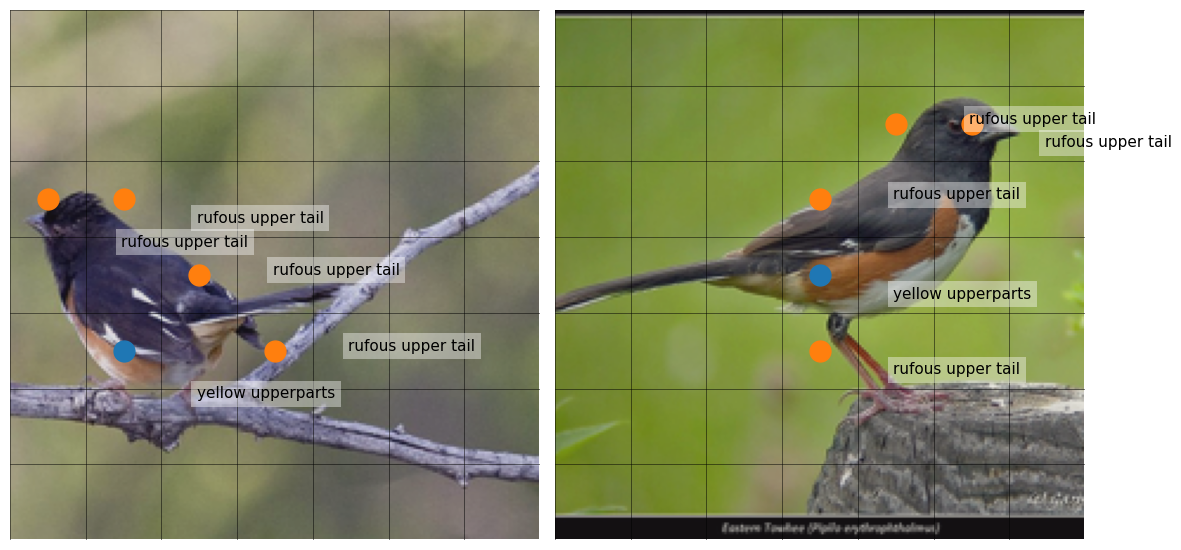

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from typing import List, Tuple

def map_patch_to_pixel(idx: int, n_cols: int, patch_size: int) -> Tuple[int, int]:
    """
    Map the patch index to the center coordinates of the patch in the image.
    :param idx: Index of the patch.
    :param n_cols: Number of patches per row.
    :param patch_size: Size of each patch (in pixels).
    :return: (y, x) center coordinates.
    """
    row = idx // n_cols
    col = idx % n_cols
    y = row * patch_size + patch_size // 2  # Offset downward by half the patch size from the top of the patch
    x = col * patch_size + patch_size // 2  # Offset rightward by half the patch size from the left of the patch
    return y, x

def draw_correspondences_with_labels_and_patches(points1: List[Tuple[float, float]], 
                                                 points2: List[Tuple[float, float]], 
                                                 labels: List[str],
                                                 image1: Image.Image, 
                                                 image2: Image.Image,
                                                 patch_size: int) -> plt.Figure:
    """
    Draw patch grids, keypoint correspondences, and labels between two images.
    
    :param points1: List of (y, x) coordinates in image1.
    :param points2: List of (y, x) coordinates in image2.
    :param labels: Corresponding list of labels (length must match points1 and points2).
    :param image1: First image (query image).
    :param image2: Second image (prototype image).
    :param patch_size: Size of each patch (in pixels).
    :return: A matplotlib figure showing both images with patch grids and annotated correspondences.
    """
    assert len(points1) == len(points2) == len(labels), \
        f"Number of points do not match: {len(points1)}, {len(points2)}, {len(labels)}"
    
    # Assign a unique color for each label
    label_colors = {label: plt.cm.tab10(i % 10) for i, label in enumerate(set(labels))}
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.axis('off')
    ax2.axis('off')
    
    # Display images
    ax1.imshow(image1)
    ax2.imshow(image2)

    # Draw patch grids
    for ax, img in zip([ax1, ax2], [image1, image2]):
        n_rows = img.height // patch_size
        n_cols = img.width // patch_size
        
        # Set axis limits to prevent gridlines from exceeding the image boundaries
        ax.set_xlim(0, img.width)
        ax.set_ylim(img.height, 0)  # The y-axis of the image coordinate system goes top-down
    
        for row in range(n_rows + 1):
            ax.axhline(y=row * patch_size, color='black', linewidth=0.5, alpha=0.7)
        for col in range(n_cols + 1):
            ax.axvline(x=col * patch_size, color='black', linewidth=0.5, alpha=0.7)

    label_positions = []  # Store bounding boxes for existing labels
    point_radius = 15  # Radius of points (corresponds to markersize)
    for point1, point2, label in zip(points1, points2, labels):
        y1, x1 = point1
        y2, x2 = point2
        color = label_colors[label]

        # Dynamically adjust label positions to avoid overlap
        def adjust_label_position(x, y, label_positions, label_length, point_radius):
            # Initial label offset: move right by the point diameter plus a fixed distance
            offset_x = point_radius * 2 + 1  # Avoid overlap with the point diameter
            offset_y = 0  # Default to no vertical offset
            bbox_width = label_length * 6  # Estimate label width (6 pixels per character)
            bbox_height = 10  # Label height
            while any(
                abs((x + offset_x) - lx) < bbox_width and abs((y + offset_y) - ly) < bbox_height
                for lx, ly, lw, lh in label_positions
            ):
                offset_y += 10  # If conflict, move the label downward
            return x + offset_x, y + offset_y

        # Draw points and labels on the first image
        ax1.plot(x1, y1, 'o', markersize=point_radius, color=color)
        adjusted_x1, adjusted_y1 = adjust_label_position(x1, y1, label_positions, len(label), point_radius)
        ax1.text(adjusted_x1, adjusted_y1, label, fontsize=11, color='black', 
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))
        label_positions.append((adjusted_x1, adjusted_y1, len(label) * 6, 10))  # Save label bounding box

        # Draw points and labels on the second image
        ax2.plot(x2, y2, 'o', markersize=point_radius, color=color)
        adjusted_x2, adjusted_y2 = adjust_label_position(x2, y2, label_positions, len(label), point_radius)
        ax2.text(adjusted_x2, adjusted_y2, label, fontsize=11, color='black', 
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))
        label_positions.append((adjusted_x2, adjusted_y2, len(label) * 6, 10))  # Save label bounding box
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Data preparation and processing logic remains unchanged
valid_correspondences = []
for query_idx, prototype_idx in zip(query_indices_to_show, prototype_indices_to_show):
    if query_idx < len(matched_labels[0]) and prototype_idx < len(matched_labels[1]):
        query_coords = map_patch_to_pixel(query_idx, n_cols, PATCH_SIZE)  # Center coordinates of query image patch
        prototype_coords = map_patch_to_pixel(prototype_idx, n_cols, PATCH_SIZE)  # Center coordinates of prototype image patch
        valid_correspondences.append((
            query_coords,
            prototype_coords,
            matched_labels[0][query_idx]  # Label from query image
        ))

# Split data for visualization
query_points, prototype_points, labels = zip(*valid_correspondences)

# Restore image colors (denormalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3).to(inputs[0].device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3).to(inputs[0].device)
denormalized_query = (inputs[0].permute(1, 2, 0) * std + mean).clamp(0, 1)
denormalized_prototype = (inputs[1].permute(1, 2, 0) * std + mean).clamp(0, 1)

# Convert to uint8 and create PIL images
query_image = Image.fromarray((denormalized_query.cpu().numpy() * 255).astype(np.uint8))
prototype_image = Image.fromarray((denormalized_prototype.cpu().numpy() * 255).astype(np.uint8))

# Draw images
fig = draw_correspondences_with_labels_and_patches(
    points1=query_points,
    points2=prototype_points,
    labels=labels,
    image1=query_image,
    image2=prototype_image,
    patch_size=PATCH_SIZE
)

# Show results
plt.show(fig)
